# Baseline Model using Opcode Entropy

## Set up

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import json
import pandas as pd
from imblearn.combine import SMOTETomek
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, f1_score


In [3]:
PATH = Path.cwd().parents[2]
DATA_PATH = os.path.join(PATH, 'data/processed/opcode_entropy')

## List Traditional ML model to compare

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier

models = {
  # MultiOutputClassifier Wrappers
  "MultiOutputClassifier(LogisticRegression())": MultiOutputClassifier(LogisticRegression()),
  "MultiOutputClassifier(DecisionTreeClassifier())": MultiOutputClassifier(DecisionTreeClassifier()),
  "MultiOutputClassifier(RandomForestClassifier())": MultiOutputClassifier(RandomForestClassifier()),
  "MultiOutputClassifier(AdaBoostClassifier())": MultiOutputClassifier(AdaBoostClassifier()),
  "MultiOutputClassifier(ExtraTreesClassifier())": MultiOutputClassifier(ExtraTreesClassifier()),
  "MultiOutputClassifier(XGBClassifier())": MultiOutputClassifier(XGBClassifier()),
  "MultiOutputClassifier(LGBMClassifier())": MultiOutputClassifier(LGBMClassifier()),
  "MultiOutputClassifier(SVC())": MultiOutputClassifier(SVC()),
  "MultiOutputClassifier(GaussianNB())": MultiOutputClassifier(GaussianNB()),
  "MultiOutputClassifier(KNeighborsClassifier())": MultiOutputClassifier(KNeighborsClassifier()),
  "MultiOutputClassifier(SGDClassifier())": MultiOutputClassifier(SGDClassifier()),
  "MultiOutputClassifier(MLPClassifier())": MultiOutputClassifier(MLPClassifier()),

  # OneVsRestClassifier Wrappers
  "OneVsRestClassifier(LogisticRegression())": OneVsRestClassifier(LogisticRegression()),
  "OneVsRestClassifier(DecisionTreeClassifier())": OneVsRestClassifier(DecisionTreeClassifier()),
  "OneVsRestClassifier(RandomForestClassifier())": OneVsRestClassifier(RandomForestClassifier()),
  "OneVsRestClassifier(AdaBoostClassifier())": OneVsRestClassifier(AdaBoostClassifier()),
  "OneVsRestClassifier(ExtraTreesClassifier())": OneVsRestClassifier(ExtraTreesClassifier()),
  "OneVsRestClassifier(XGBClassifier())": OneVsRestClassifier(XGBClassifier()),
  "OneVsRestClassifier(LGBMClassifier())": OneVsRestClassifier(LGBMClassifier()),
  "OneVsRestClassifier(SVC())": OneVsRestClassifier(SVC()),
  "OneVsRestClassifier(GaussianNB())": OneVsRestClassifier(GaussianNB()),
  "OneVsRestClassifier(KNeighborsClassifier())": OneVsRestClassifier(KNeighborsClassifier()),
  "OneVsRestClassifier(SGDClassifier())": OneVsRestClassifier(SGDClassifier()),
  "OneVsRestClassifier(MLPClassifier())": OneVsRestClassifier(MLPClassifier()),
}

## Load Dataset

In [5]:
df = pd.read_csv(os.path.join(DATA_PATH, 'dataset.csv')).set_index('address')

with open(os.path.join(DATA_PATH, 'features.json'), "r") as f:
    features = json.load(f)

with open(os.path.join(DATA_PATH, 'labels.json'), "r") as f:
    labels = json.load(f)

In [6]:
df.head()

,mint,leak,limit,opcode_entropy
address,,,,
0x93023f1d3525e273f291b6f76d2f5027a39bf302,1,0,1,3.588720
0x2753dce37a7edb052a77832039bcc9aa49ad8b25,0,0,1,3.605842
0x94b7d24552933f50a5a5705c446528806dcea381,0,0,0,3.941392
0xe0b9d4146aad6936cbfcbe4dae47e34aab96b093,0,0,0,3.566705
0x10f6f2b97f3ab29583d9d38babf2994df7220c21,1,0,1,3.577189


In [7]:
features[:5]

['opcode_entropy']

In [8]:
labels[:5]

['mint', 'leak', 'limit']

## Prepare Features and Labels

In [9]:
X = df[features]
y = df[labels]

## Train/Test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Apply SMOTETomek

✅ Resampled shapes: (188, 1) (188, 3)


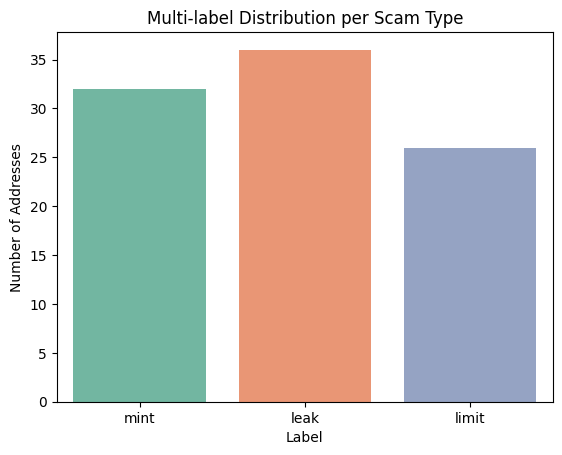

In [11]:
X_train_resampled = pd.DataFrame()
y_train_resampled = pd.DataFrame()

for i, label in enumerate(y_train.columns):
    smt = SMOTETomek(random_state=42)
    X_res, y_res = smt.fit_resample(X_train, y_train[label])

    df_X_res = pd.DataFrame(X_res)
    df_y_res = pd.DataFrame(y_res, columns=[label])

    # Concatenate features and label to one DF
    df_res = pd.concat([df_X_res, df_y_res], axis=1)

    # Append and fill missing values with 0 (i.e., assume the label wasn't assigned)
    X_train_resampled = pd.concat([X_train_resampled, df_res], axis=0)

# After all labels processed, separate X and y again
X_train_resampled = X_train_resampled.drop_duplicates().reset_index(drop=True)
y_train_resampled = X_train_resampled[y_train.columns].fillna(0).astype(int)
X_train_resampled = X_train_resampled.drop(columns=y_train.columns)

print("✅ Resampled shapes:", X_train_resampled.shape, y_train_resampled.shape)

label_counts = y_train_resampled[["mint", "leak", "limit"]].sum()

sns.barplot(x=label_counts.index, y=label_counts.values, palette="Set2")
plt.title("Multi-label Distribution per Scam Type")
plt.xlabel("Label")
plt.ylabel("Number of Addresses")
plt.show()

## Run all models and collect reports

In [12]:
def get_report_all_ml(X_train, y_train, X_test):
    report_list = []

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Generate classification report (as dict)
        report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

        # Average scores across all labels (macro average)
        avg_scores = report_dict["macro avg"]

        report_list.append({
            "Model": name,
            "Precision": avg_scores["precision"],
            "Recall": avg_scores["recall"],
            "F1-score": avg_scores["f1-score"]
        })

    df_report = pd.DataFrame(report_list)
    df_report = df_report.sort_values("F1-score", ascending=False).reset_index(drop=True)

    return df_report

## Show report

In [13]:
def display_multilabel_confusion_matrix(y_test, y_pred):
    # Ensure y_test and y_pred are binary numeric arrays
    y_test_array = np.array(y_test, dtype=int)
    y_pred_array = np.array(y_pred, dtype=int)

    # Generate multi-label confusion matrix again using numeric arrays
    conf_matrices_fixed = multilabel_confusion_matrix(y_test_array, y_pred_array)

    # Plot each confusion matrix again to confirm it's fixed
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    for i, (cm, label) in enumerate(zip(conf_matrices_fixed, y.columns)):
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f'Confusion Matrix: {label}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

In [14]:
df_report_smote = get_report_all_ml(X_train_resampled, y_train_resampled, X_test)
df_report_smote

[LightGBM] [Info] Number of positive: 32, number of negative: 156
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56
[LightGBM] [Info] Number of data points in the train set: 188, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.170213 -> initscore=-1.584120
[LightGBM] [Info] Start training from score -1.584120
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

,Model,Precision,Recall,F1-score
0,MultiOutputClassifier(XGBClassifier()),0.500000,0.222222,0.300000
1,OneVsRestClassifier(XGBClassifier()),0.500000,0.222222,0.300000
2,MultiOutputClassifier(SGDClassifier()),0.214286,0.333333,0.260870
3,OneVsRestClassifier(KNeighborsClassifier()),0.500000,0.166667,0.250000
4,MultiOutputClassifier(KNeighborsClassifier()),0.500000,0.166667,0.250000
5,MultiOutputClassifier(LGBMClassifier()),0.416667,0.166667,0.233333
6,OneVsRestClassifier(LGBMClassifier()),0.416667,0.166667,0.233333
7,OneVsRestClassifier(SGDClassifier()),0.138889,0.277778,0.185185
8,OneVsRestClassifier(ExtraTreesClassifier()),0.166667,0.166667,0.166667
9,MultiOutputClassifier(DecisionTreeClassifier()),0.166667,0.166667,0.166667


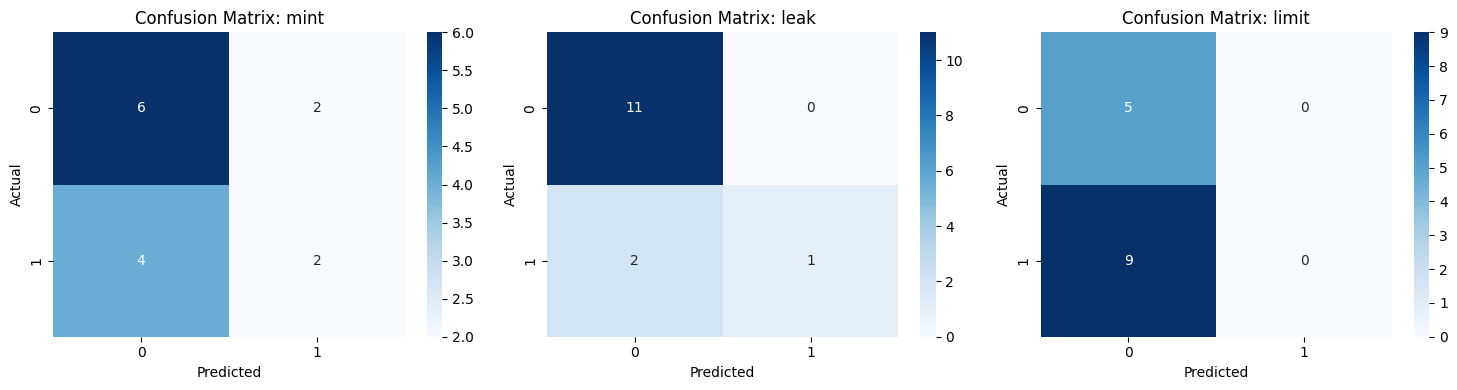

In [15]:
best_model = models[df_report_smote['Model'][0]]
y_pred = best_model.predict(X_test)

display_multilabel_confusion_matrix(y_test, y_pred)

In [16]:
df_report = get_report_all_ml(X_train, y_train, X_test)
df_report

[LightGBM] [Info] Number of positive: 14, number of negative: 41
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20
[LightGBM] [Info] Number of data points in the train set: 55, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.254545 -> initscore=-1.074515
[LightGBM] [Info] Start training from score -1.074515
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

,Model,Precision,Recall,F1-score
0,MultiOutputClassifier(XGBClassifier()),0.533333,0.277778,0.348485
1,OneVsRestClassifier(XGBClassifier()),0.533333,0.277778,0.348485
2,MultiOutputClassifier(ExtraTreesClassifier()),0.261905,0.185185,0.205128
3,MultiOutputClassifier(DecisionTreeClassifier()),0.261905,0.185185,0.205128
4,OneVsRestClassifier(DecisionTreeClassifier()),0.261905,0.185185,0.205128
5,OneVsRestClassifier(ExtraTreesClassifier()),0.261905,0.185185,0.205128
6,OneVsRestClassifier(RandomForestClassifier()),0.261905,0.185185,0.205128
7,MultiOutputClassifier(RandomForestClassifier()),0.261905,0.185185,0.205128
8,OneVsRestClassifier(LGBMClassifier()),0.190476,0.148148,0.166667
9,MultiOutputClassifier(LGBMClassifier()),0.190476,0.148148,0.166667


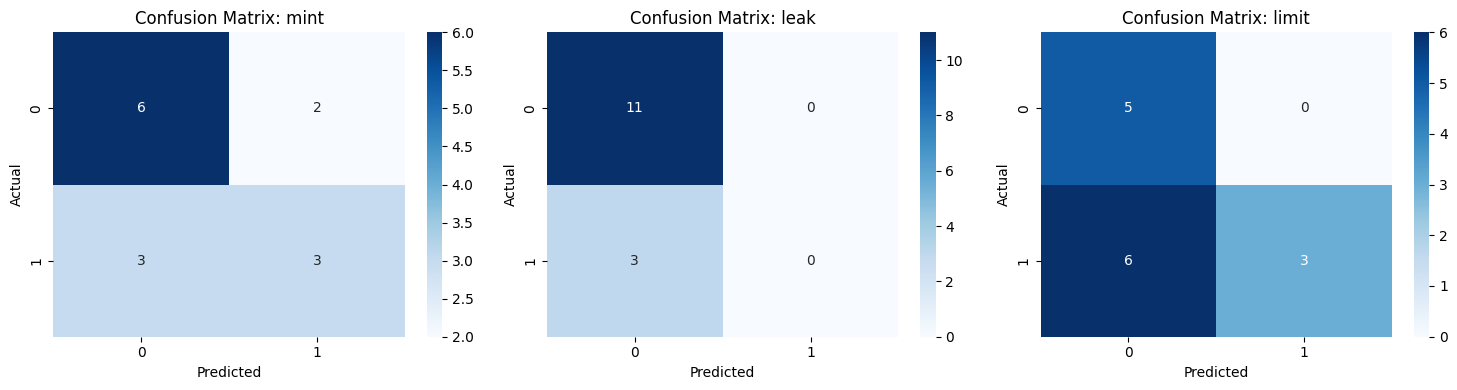

In [17]:
best_model = models[df_report['Model'][0]]
y_pred = best_model.predict(X_test)

display_multilabel_confusion_matrix(y_test, y_pred)

In [18]:
labels = y.columns.tolist()  # assuming y is a pandas DataFrame

for i, label in enumerate(labels):
    report_dict = classification_report(y_test[label], y_pred[:, i], output_dict=True)
    f1 = report_dict["macro avg"]["f1-score"]
    print(f"{label}, f1-score: {f1}")

mint, f1-score: 0.625668449197861
leak, f1-score: 0.44
limit, f1-score: 0.5625


## Tuning

In [19]:
def get_estimator(trial, base):
    match base:
        case "LogisticRegression":
            return LogisticRegression(
                C=trial.suggest_float("C", 1e-4, 10.0, log=True),
                max_iter=trial.suggest_int("max_iter", 100, 1000),
                solver="lbfgs",
                random_state=42
            )

        case "DecisionTreeClassifier":
            return DecisionTreeClassifier(
                max_depth=trial.suggest_int("max_depth", 3, 20),
                min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
                min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 10),
                random_state=42
            )

        case "RandomForestClassifier":
            return RandomForestClassifier(
                n_estimators=trial.suggest_int("n_estimators", 100, 1000),
                max_depth=trial.suggest_int("max_depth", 3, 20),
                min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
                min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 10),
                random_state=42,
                n_jobs=-1
            )

        case "AdaBoostClassifier":
            return AdaBoostClassifier(
                n_estimators=trial.suggest_int("n_estimators", 100, 1000),
                learning_rate=trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
                random_state=42
            )

        case "ExtraTreesClassifier":
            return ExtraTreesClassifier(
                n_estimators=trial.suggest_int("n_estimators", 100, 1000),
                max_depth=trial.suggest_int("max_depth", 3, 20),
                min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
                min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 10),
                random_state=42,
                n_jobs=-1
            )

        case "XGBClassifier":
            return XGBClassifier(
                n_estimators=trial.suggest_int("n_estimators", 100, 1000),
                max_depth=trial.suggest_int("max_depth", 3, 20),
                learning_rate=trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
                subsample=trial.suggest_float("subsample", 0.5, 1.0),
                colsample_bytree=trial.suggest_float("colsample_bytree", 0.5, 1.0),
                use_label_encoder=False,
                eval_metric="logloss",
                random_state=42,
                n_jobs=-1
            )

        case "LGBMClassifier":
            return LGBMClassifier(
                n_estimators=trial.suggest_int("n_estimators", 100, 1000),
                max_depth=trial.suggest_int("max_depth", 3, 20),
                learning_rate=trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
                subsample=trial.suggest_float("subsample", 0.5, 1.0),
                colsample_bytree=trial.suggest_float("colsample_bytree", 0.5, 1.0),
                random_state=42,
                n_jobs=-1
            )

        case "SVC":
            return SVC(
                C=trial.suggest_float("C", 0.1, 10.0),
                kernel=trial.suggest_categorical("kernel", ["linear", "rbf", "poly"]),
                gamma=trial.suggest_categorical("gamma", ["scale", "auto"]),
                probability=True
            )

        case "GaussianNB":
            return GaussianNB()  # No major hyperparameters to tune

        case "KNeighborsClassifier":
            return KNeighborsClassifier(
                n_neighbors=trial.suggest_int("n_neighbors", 1, 7),
                weights=trial.suggest_categorical("weights", ["uniform", "distance"]),
                p=trial.suggest_int("p", 1, 2)  # 1 = manhattan, 2 = euclidean
            )

        case "SGDClassifier":
            return SGDClassifier(
                loss=trial.suggest_categorical("loss", ["hinge", "log_loss", "modified_huber"]),
                penalty=trial.suggest_categorical("penalty", ["l2", "l1", "elasticnet"]),
                alpha=trial.suggest_float("alpha", 1e-6, 1e-1, log=True),
                max_iter=trial.suggest_int("max_iter", 100, 1000),
                random_state=42
            )

        case "MLPClassifier":
            return MLPClassifier(
                hidden_layer_sizes=trial.suggest_categorical("hidden_layer_sizes", [(100,), (50, 50), (100, 50)]),
                activation=trial.suggest_categorical("activation", ["relu", "tanh"]),
                solver=trial.suggest_categorical("solver", ["adam", "sgd"]),
                alpha=trial.suggest_float("alpha", 1e-6, 1e-1, log=True),
                learning_rate=trial.suggest_categorical("learning_rate", ["constant", "adaptive"]),
                max_iter=trial.suggest_int("max_iter", 300, 1000),
                random_state=42
            )

        case _:
            raise NotImplementedError(f"No tuning config for: {base}")


In [20]:
def get_best_model_name(df_report=df_report):
    model_name = df_report['Model'][0]
    wrapper_name = model_name.split("(")[0]
    base = model_name[model_name.find("(")+1 : model_name.find(")")-1]
    return wrapper_name, base

In [21]:
def objective(trial):
    wrapper_name, base = get_best_model_name()

    estimator = get_estimator(trial, base)

    if "MultiOutputClassifier" in wrapper_name:
        model = MultiOutputClassifier(estimator)
    elif "OneVsRestClassifier" in wrapper_name:
        model = OneVsRestClassifier(estimator)
    else:
        raise NotImplementedError(f"Unknown wrapper: {wrapper_name}")

    scores = cross_val_score(
        model,
        X_train,
        y_train,
        scoring=make_scorer(f1_score, average='macro', zero_division=0),
        cv=3,
        n_jobs=-1
    )

    return np.mean(scores)


In [22]:
import optuna

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)  # You can increase n_trials for better tuning

[I 2025-07-15 15:09:54,139] A new study created in memory with name: no-name-cf7c4e63-e4c2-487c-8027-953ccc86e0c7
/usr/local/anaconda3/envs/ml-algo/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:10:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/anaconda3/envs/ml-algo/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:10:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/anaconda3/envs/ml-algo/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:10:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/anaconda3/envs/ml-algo/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:10:00] W

In [23]:
print("Best score (macro F1):", study.best_value)
print("Best trial params:", study.best_trial.params)


Best score (macro F1): 0.3027133360466694
Best trial params: {'n_estimators': 938, 'max_depth': 11, 'learning_rate': 0.0037549375014938975, 'subsample': 0.8392625095060761, 'colsample_bytree': 0.5543948887454566}


In [24]:
# Extract model name
wrapper_name, base = get_best_model_name()

# Get best tuned estimator
best_base_model = get_estimator(study.best_trial, base)

# Wrap it again
if "MultiOutputClassifier" in wrapper_name:
    best_model_tuned = MultiOutputClassifier(best_base_model)
elif "OneVsRestClassifier" in wrapper_name:
    best_model_tuned = OneVsRestClassifier(best_base_model)
else:
    raise NotImplementedError(f"Unknown wrapper: {wrapper_name}")


In [25]:
best_model_tuned.fit(X_train, y_train)

MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.5543948887454566,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=0.0037549375014938975,
                                              max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=11,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=938, n_jobs=-1,
                                              num_parallel_tree=None,
                                              random_state=42, ...))

In [26]:
y_pred = best_model_tuned.predict(X_test)

In [27]:
print(classification_report(y_test, y_pred, target_names=y.columns))

              precision    recall  f1-score   support

        mint       1.00      0.17      0.29         6
        leak       0.00      0.00      0.00         3
       limit       1.00      0.33      0.50         9

   micro avg       1.00      0.22      0.36        18
   macro avg       0.67      0.17      0.26        18
weighted avg       0.83      0.22      0.35        18
 samples avg       0.21      0.18      0.19        18



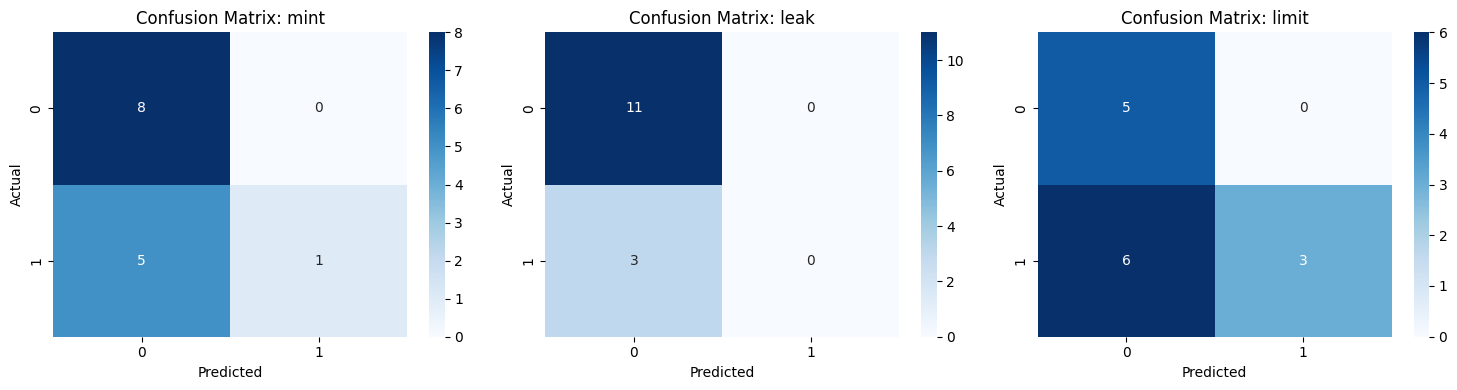

In [28]:
display_multilabel_confusion_matrix(y_test, y_pred)

## MLP

### Build model

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import MeanSquaredError

2025-07-15 15:10:37.867218: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [30]:
def Model(input_dim, output_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(512, kernel_regularizer=regularizers.l1_l2(1e-6)),
        BatchNormalization(),
        LeakyReLU(0.01),
        Dropout(0.4),

        Dense(256, kernel_regularizer=regularizers.l1_l2(1e-6)),
        BatchNormalization(),
        LeakyReLU(0.01),
        Dropout(0.3),

        Dense(128, kernel_regularizer=regularizers.l1_l2(1e-6)),
        BatchNormalization(),
        LeakyReLU(0.01),
        Dropout(0.2),

        Dense(output_dim, activation='sigmoid')  # sigmoid for multi-label
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=1e-6),
        metrics=['accuracy']
    )
    return model

In [31]:
model = Model(input_dim=X.shape[1], output_dim=y.shape[1])

### Train

In [32]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32,
                    callbacks=[
                                EarlyStopping(monitor='val_loss',
                                             patience=5,
                                             restore_best_weights=True),
                                ReduceLROnPlateau(
                                  monitor='val_loss',
                                  factor=0.5,
                                  patience=5,
                                  verbose=1)
                               ]
                    )

Epoch 1/100


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 313ms/step - accuracy: 0.3059 - loss: 0.8518 - val_accuracy: 0.5455 - val_loss: 0.7044 - learning_rate: 1.0000e-06
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.3722 - loss: 0.8001 - val_accuracy: 0.5455 - val_loss: 0.7023 - learning_rate: 1.0000e-06
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.4896 - loss: 0.8454 - val_accuracy: 0.5455 - val_loss: 0.7009 - learning_rate: 1.0000e-06
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4848 - loss: 0.8552 - val_accuracy: 0.5455 - val_loss: 0.6991 - learning_rate: 1.0000e-06
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.4896 - loss: 0.9030 - val_accuracy: 0.5455 - val_loss: 0.6976 - learning_rate: 1.0000e-06
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.5000 - loss: 0.8702 - val_accuracy: 0.5455 - val_loss: 0.6958 - learning_rate: 1.0000e-06
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.4489 - loss: 0.8921 -

### Predict

In [33]:
y_test_prob = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


In [34]:
def tune_thresholds(y_true, y_pred_prob, metric='f1'):
    y_true = np.asarray(y_true)          # Fix: convert to NumPy
    y_pred_prob = np.asarray(y_pred_prob)

    best_thresholds = []
    best_scores = []

    for i in range(y_true.shape[1]):
        label_true = y_true[:, i]
        label_probs = y_pred_prob[:, i]  # Fix here too

        thresholds = np.linspace(0.0, 1.0, 101)
        scores = []

        for t in thresholds:
            label_pred = (label_probs >= t).astype(int)
            if metric == 'f1':
                score = f1_score(label_true, label_pred, zero_division=0)
            scores.append(score)

        best_t = thresholds[np.argmax(scores)]
        best_score = np.max(scores)

        best_thresholds.append(best_t)
        best_scores.append(best_score)

        print(f"Label {i}: Best threshold = {best_t:.2f}, Best {metric} = {best_score:.4f}")

    return best_thresholds, best_scores


In [35]:
best_thresholds, _ = tune_thresholds(y_test, y_test_prob)

Label 0: Best threshold = 0.00, Best f1 = 0.6000
Label 1: Best threshold = 0.33, Best f1 = 0.4000
Label 2: Best threshold = 0.00, Best f1 = 0.7826


In [36]:
y_pred = (model.predict(X_test) >= best_thresholds).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


### Report

In [37]:
print(classification_report(y_test, y_pred, target_names=y.columns))

              precision    recall  f1-score   support

        mint       0.43      1.00      0.60         6
        leak       0.25      1.00      0.40         3
       limit       0.64      1.00      0.78         9

   micro avg       0.45      1.00      0.62        18
   macro avg       0.44      1.00      0.59        18
weighted avg       0.51      1.00      0.66        18
 samples avg       0.45      0.71      0.54        18



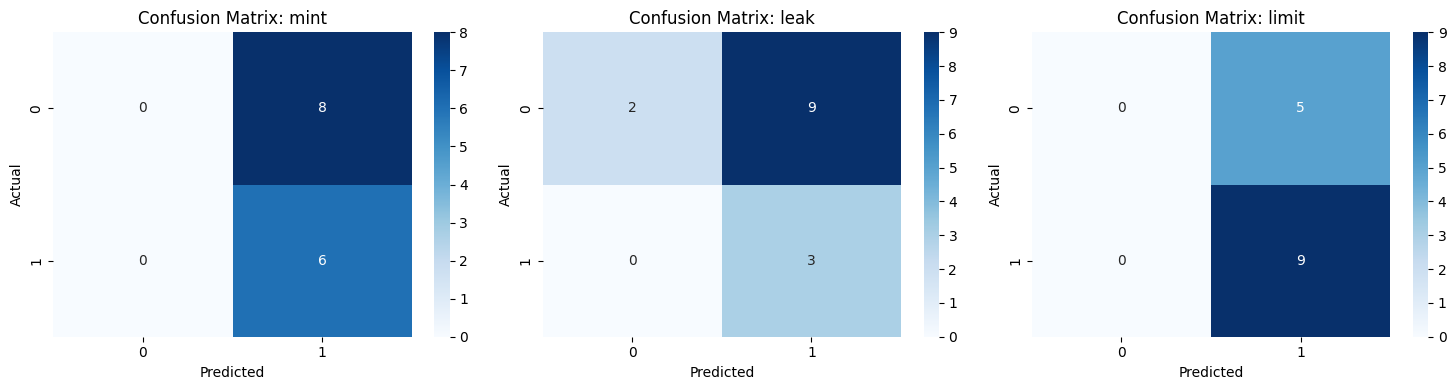

In [38]:
display_multilabel_confusion_matrix(y_test, y_pred)

## Autoencoder + MPL

In [39]:
def Autoencoder(input_dim=256):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128),
        LeakyReLU(0.01),

        Dense(32),
        BatchNormalization(),
        LeakyReLU(0.01),

        Dense(128),
        BatchNormalization(),
        LeakyReLU(0.01),

        Dense(input_dim, activation='sigmoid')  # sigmoid for multi-label
    ])

    model.compile(optimizer=Adam(1e-6), loss=MeanSquaredError())
    return model


In [40]:
autoencoder = Autoencoder(input_dim=X.shape[1])
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 361ms/step - loss: 10.2265 - val_loss: 10.7488
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 10.3652 - val_loss: 10.7467
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 10.3590 - val_loss: 10.7448
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 10.3638 - val_loss: 10.7428
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 10.3362 - val_loss: 10.7406
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 10.3589 - val_loss: 10.7385
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 10.3353 - val_loss: 10.7366
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 10.3082 - val_loss: 10.7340
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 10.3590 - val_loss: 10.7316
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 10.3428 - val_loss: 10.7288
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 10.3204 - val_loss: 10.7262
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 10.4

In [41]:
X_train_encoded = autoencoder.predict(X_train)
X_test_encoded = autoencoder.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [42]:
model = Model(input_dim=X_train_encoded.shape[1], output_dim=y.shape[1])

In [43]:
history = model.fit(X_train_encoded, y_train, validation_split=0.2, epochs=100, batch_size=32,
                    callbacks=[
                                EarlyStopping(monitor='val_loss',
                                             patience=5,
                                             restore_best_weights=True),
                                ReduceLROnPlateau(
                                  monitor='val_loss',
                                  factor=0.5,
                                  patience=5,
                                  verbose=1)
                               ]
                    )

Epoch 1/100


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 299ms/step - accuracy: 0.3570 - loss: 0.7859 - val_accuracy: 0.3636 - val_loss: 0.6986 - learning_rate: 1.0000e-06
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.2907 - loss: 0.8239 - val_accuracy: 0.3636 - val_loss: 0.6985 - learning_rate: 1.0000e-06
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.2500 - loss: 0.8161 - val_accuracy: 0.3636 - val_loss: 0.6984 - learning_rate: 1.0000e-06
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.4186 - loss: 0.8006 - val_accuracy: 0.3636 - val_loss: 0.6983 - learning_rate: 1.0000e-06
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.3930 - loss: 0.8577 - val_accuracy: 0.3636 - val_loss: 0.6982 - learning_rate: 1.0000e-06
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.3059 - loss: 0.8274 - val_accuracy: 0.3636 - val_loss: 0.6981 - learning_rate: 1.0000e-06
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.3731 - loss: 0.8306 - v

In [44]:
y_pred_prob = model.predict(X_test_encoded)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


In [45]:
best_thresholds, _ = tune_thresholds(y_test, y_test_prob)

Label 0: Best threshold = 0.00, Best f1 = 0.6000
Label 1: Best threshold = 0.33, Best f1 = 0.4000
Label 2: Best threshold = 0.00, Best f1 = 0.7826


In [46]:
y_pred = (model.predict(X_test) >= best_thresholds).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


### Report

In [47]:
print(classification_report(y_test, y_pred, target_names=y.columns))

              precision    recall  f1-score   support

        mint       0.43      1.00      0.60         6
        leak       0.00      0.00      0.00         3
       limit       0.64      1.00      0.78         9

   micro avg       0.54      0.83      0.65        18
   macro avg       0.36      0.67      0.46        18
weighted avg       0.46      0.83      0.59        18
 samples avg       0.54      0.62      0.56        18



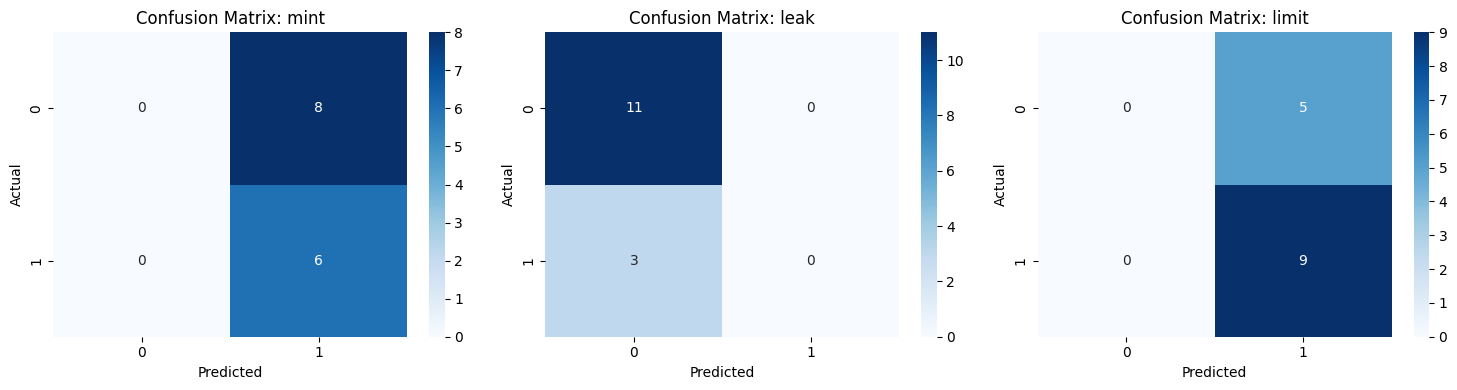

In [48]:
display_multilabel_confusion_matrix(y_test, y_pred)